### Задача

Построить распределение уверенности предсказания модели.

### Inference

In [1]:
import json

path_anns = '../data/datasets/original/annotations/default.json'

with open(path_anns, 'r') as f:
    data = json.load(f)

list_labels = [d['name'] for d in data['categories']['label']['labels']]
print(list_labels)

['room', 'bathroom', 'inner_corridor', 'public_place', 'floor_finish', 'floor_init', 'ceiling_finish', 'wall_finish', 'wall_init', 'door_room', 'toilet_yes', 'bath_yes', 'esocket_yes', 'kitchen_furniture_yes', 'radiator', 'floor_without', 'ceiling_without', 'wall_without', 'window_trim', 'window', 'floor_pipes', 'garbage', 'place_door', 'place_radiator', 'ventilation_shaft', 'sink_yes', 'conditioner', 'smoke_detector', 'ventilation_grille', 'fire_detectors', 'dynamics', 'switch_box_flat', 'switch_box_public', 'xbk', 'water_pipes_mop', 'water_pipes_flat', 'water_meter', 'heating_riser', 'smoke_exhaust_valve', 'electrical_cable', 'electrical_riser', 'lamp', 'door_mop', 'door_entrance', 'socket_box', 'tongue_groove _blocks', 'tile_plinth', 'pantry', 'bad_light']


In [2]:
from pathlib import Path

n_classes = len(list_labels)
name_experiment = 'augoff'
device = 'cuda:0'
batch_size = 256
threshold = 0.5

path_weights = f'../logs/{name_experiment}/'
path_weights = list(Path(path_weights).rglob('*.pth'))[0]
print(path_weights)

path_imgs = '../data/datasets/original/images/default'
path_csv_test = '../data/datasets/csv/test.csv'

../logs/augoff/augoff_prec_0.779.pth


In [3]:
import cv2
import timm
import torch
from tqdm import tqdm
from pathlib import Path


model = timm.create_model('convnext_large_in22k', pretrained=False, num_classes=n_classes)
checkpoint = torch.load(path_weights)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=768, out_features=192, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (norm): LayerNorm((192,), eps=1e-06, elemen

In [7]:
import albumentations as A
import albumentations.pytorch



train_transforms = A.Compose(
                                [
                                    A.Resize(width=224, height=224),        
                                    A.Normalize(
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225],
                                        max_pixel_value=255.0,
                                    ),
                                    
                                    A.pytorch.ToTensorV2()
    ]
)

val_transforms = A.Compose(
                                [
                                    A.Resize(width=224, height=224),
                                    A.Normalize(
                                            mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225],
                                            max_pixel_value=255.0,
                                        ),

                                    A.pytorch.ToTensorV2()
    ]
)

test_transforms = val_transforms

In [5]:
import cv2
import torch
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader



class ImageDataset(Dataset):
    def __init__(self, path_csv: str, path_imgs: str, transforms=None):
        """
        :param path_imgs: path to image folder.
        """

        self.df = pd.read_csv(path_csv)
        self.path_imgs = path_imgs
        self.transforms = transforms
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        file_name = self.df.iloc[index, 0]
        path_img = f'{self.path_imgs}/{file_name}.jpg'

        img = cv2.imread(path_img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            transformered = self.transforms(image=img)
            img = transformered['image']
            
        
        targets = self.df.iloc[index, 1:]
        targets = torch.tensor(targets, dtype=torch.float32)
        
        return {
            'image': img,
            'targets': targets,
            'path_img': path_img
        }

In [8]:
ds_test = ImageDataset(path_csv_test, path_imgs, test_transforms)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

In [15]:
import numpy as np


all_preds = np.array([]).reshape(0, n_classes) 

model.eval()
with torch.no_grad():
    for data in tqdm(dl_test):
        data, targets = data['image'].to(device), data['targets'].to(device)
            
        outputs = model(data)
        outputs = torch.sigmoid(outputs)
                
        all_preds = np.vstack((all_preds, outputs.detach().cpu()))

 17%|█▋        | 2/12 [00:27<02:20, 14.02s/it]Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3038 extraneous bytes before marker 0xd9
100%|██████████| 12/12 [02:42<00:00, 13.56s/it]


In [17]:
all_preds

array([[9.34749246e-01, 5.72687900e-03, 1.80821866e-02, ...,
        1.84286125e-06, 1.55712569e-05, 5.06770157e-04],
       [7.50932959e-05, 2.06691897e-04, 1.23081292e-04, ...,
        4.18755750e-04, 5.38265112e-06, 1.04079365e-04],
       [3.92033427e-04, 6.50674431e-03, 1.40719274e-02, ...,
        2.30316018e-05, 1.11368965e-04, 9.97370720e-01],
       ...,
       [2.90832063e-03, 3.07124312e-04, 5.13299048e-01, ...,
        3.16018377e-05, 2.08681435e-04, 3.33797606e-03],
       [2.71079451e-01, 1.21939310e-03, 4.85946178e-01, ...,
        4.22938854e-01, 1.23835139e-06, 1.08609645e-04],
       [8.31297934e-02, 1.46879479e-02, 3.26264560e-01, ...,
        1.89546427e-05, 2.75763236e-02, 3.32423113e-02]])

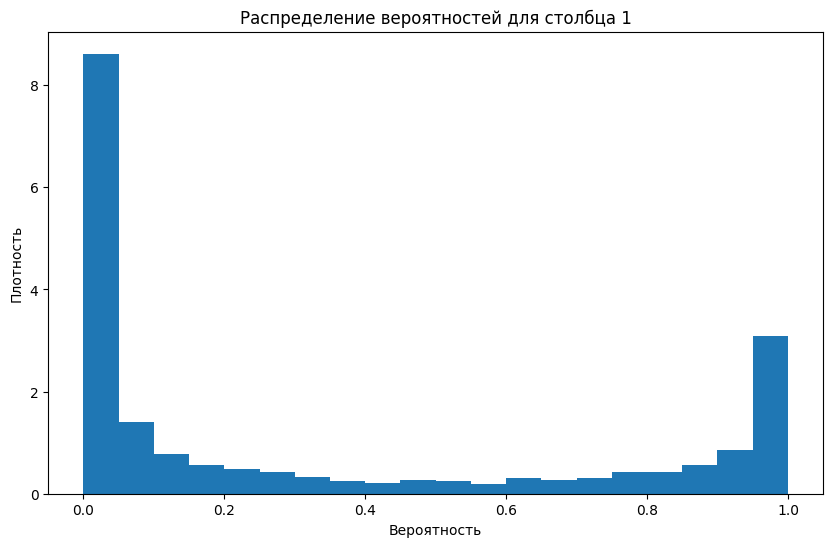

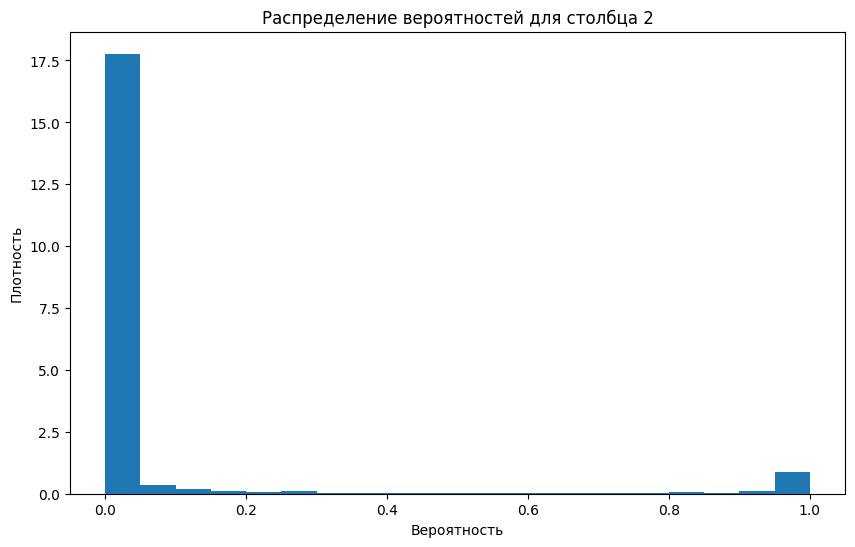

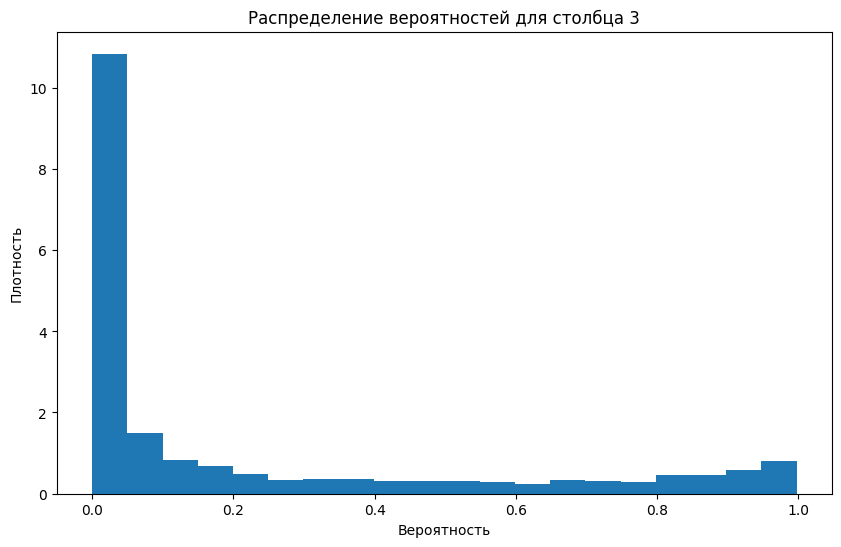

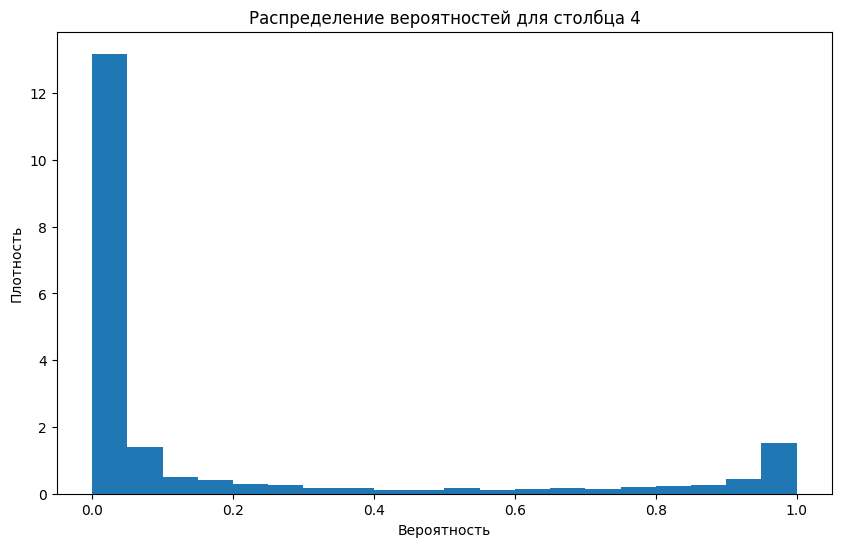

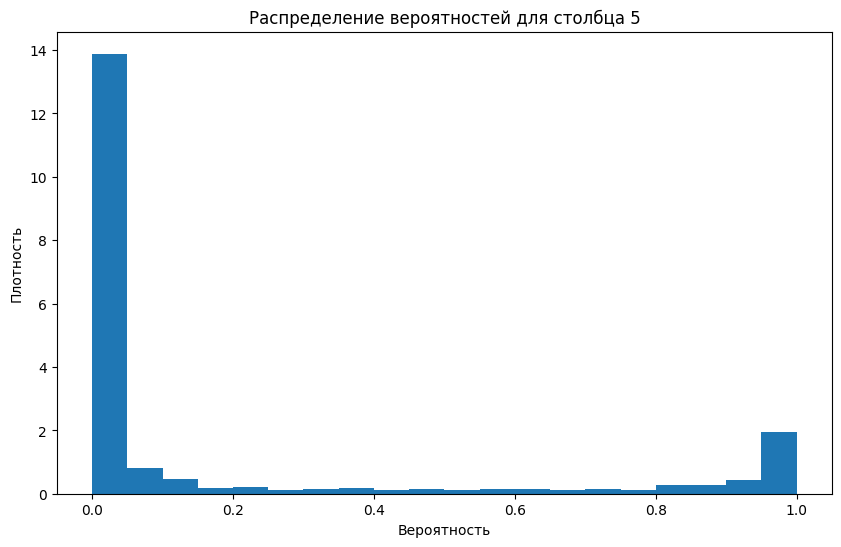

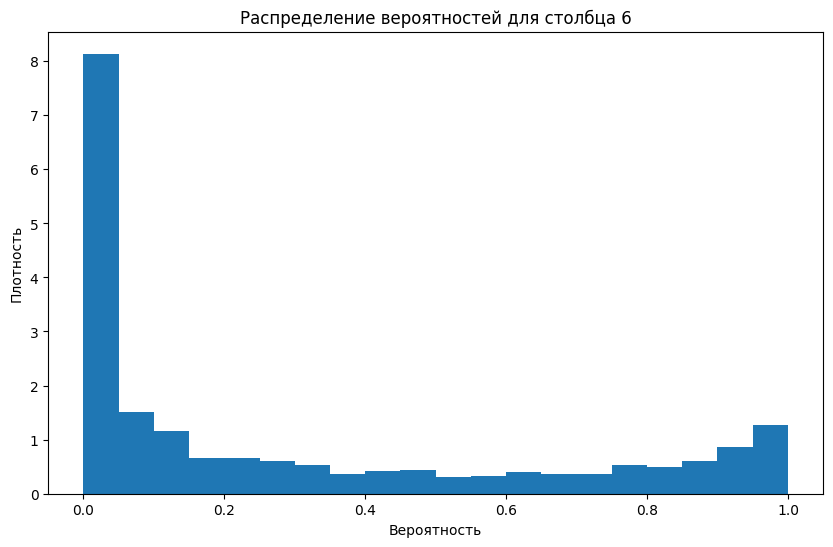

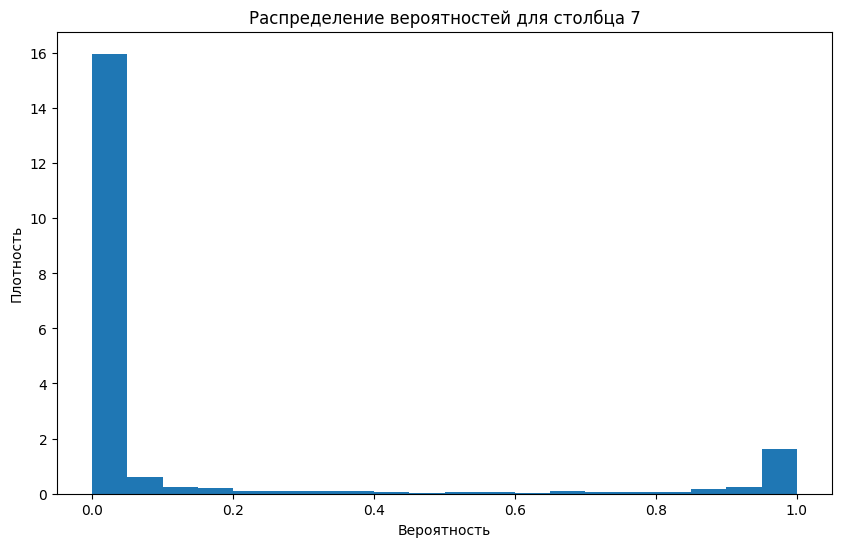

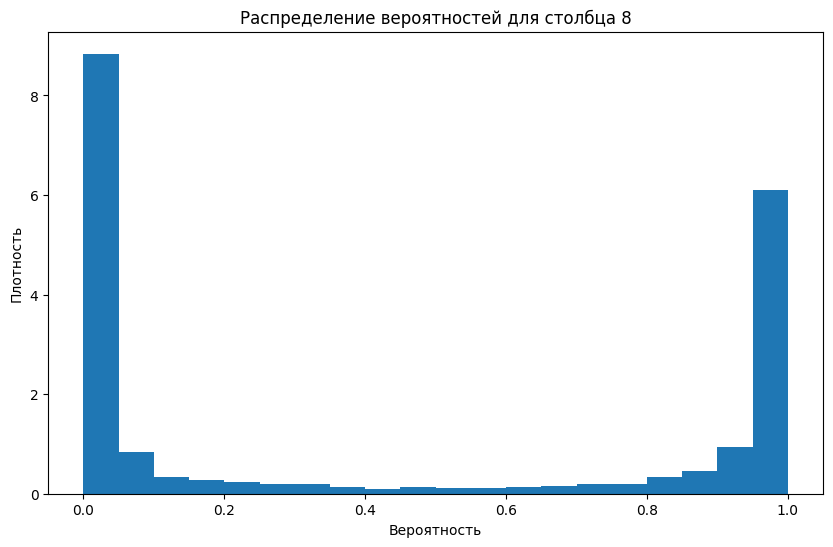

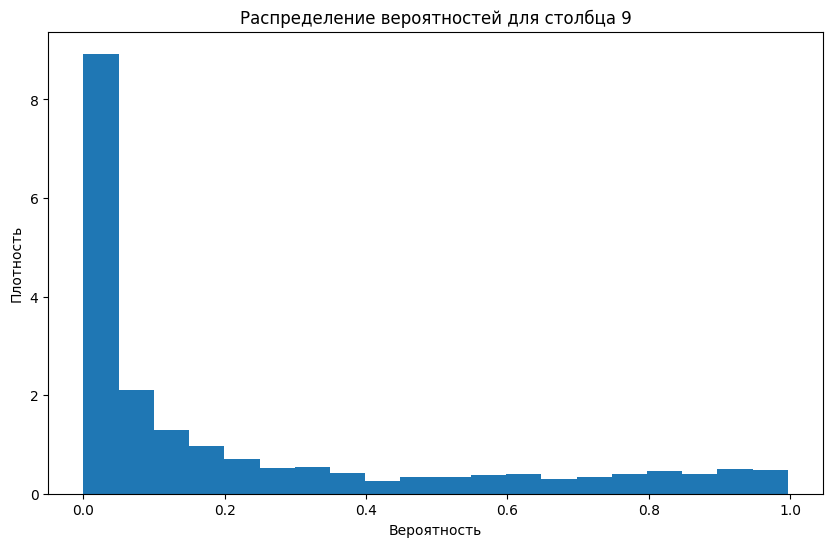

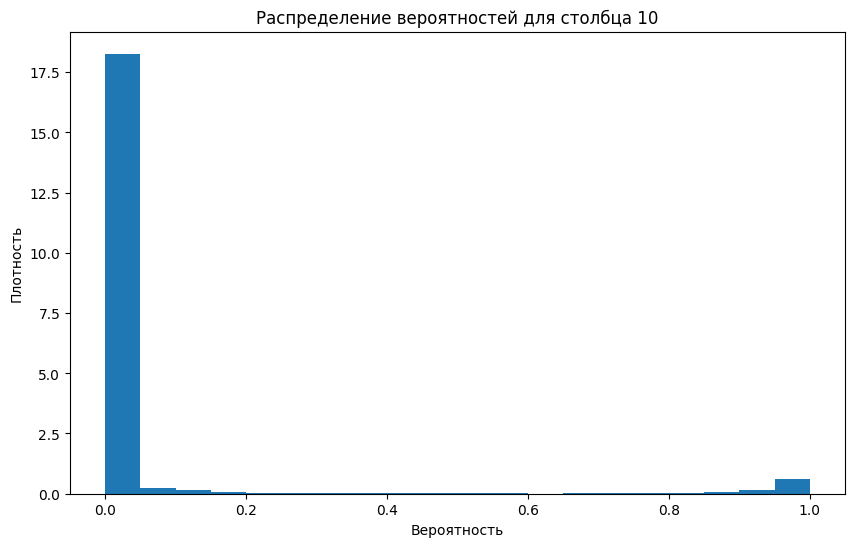

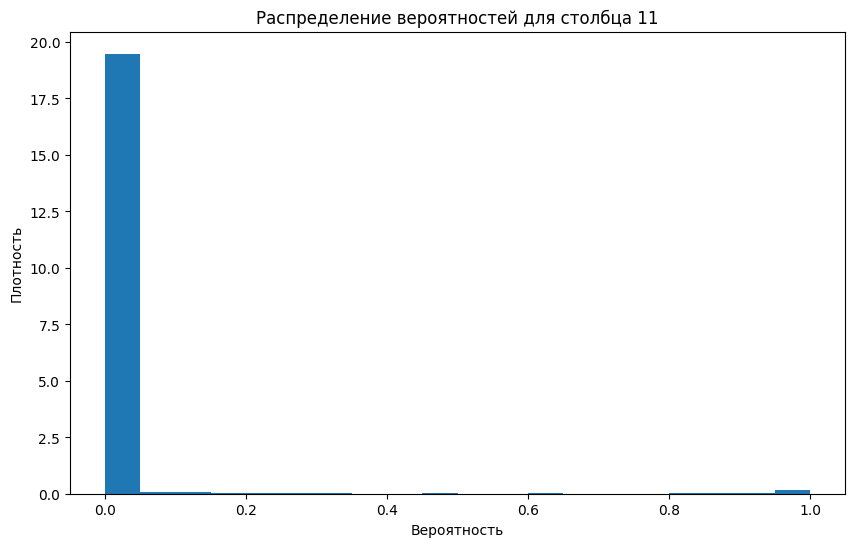

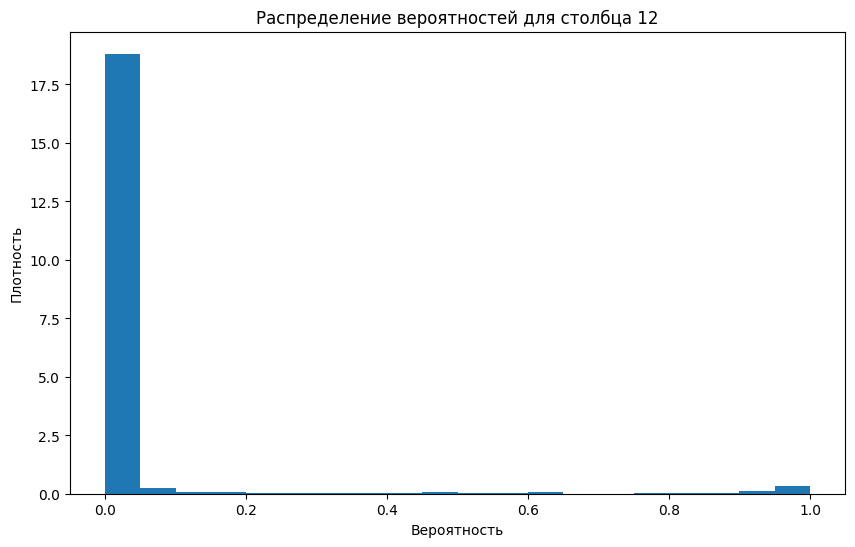

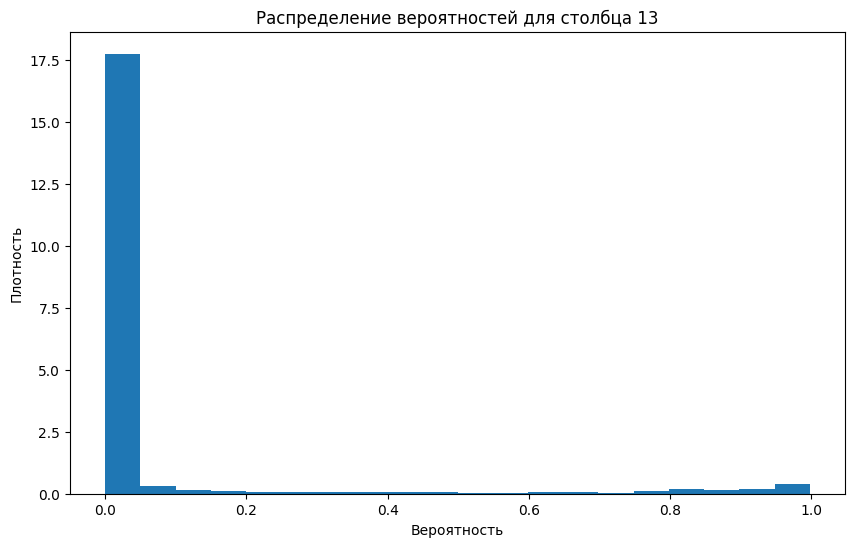

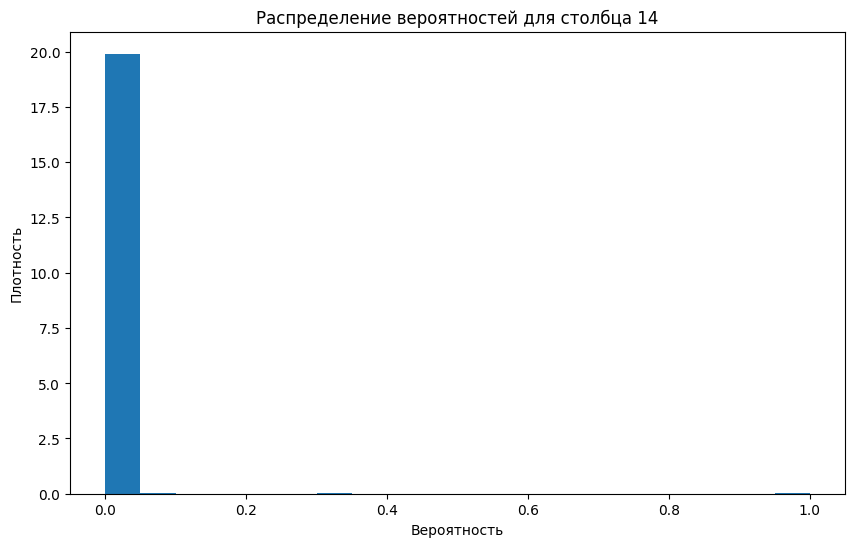

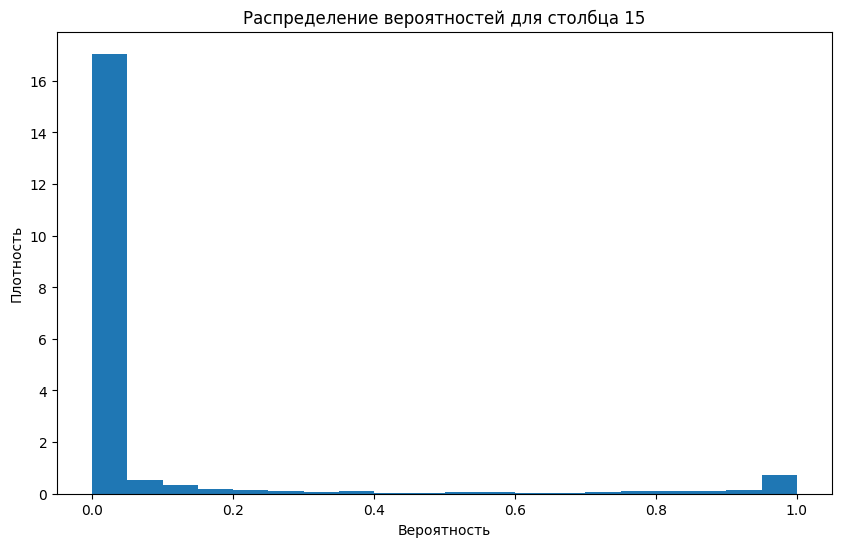

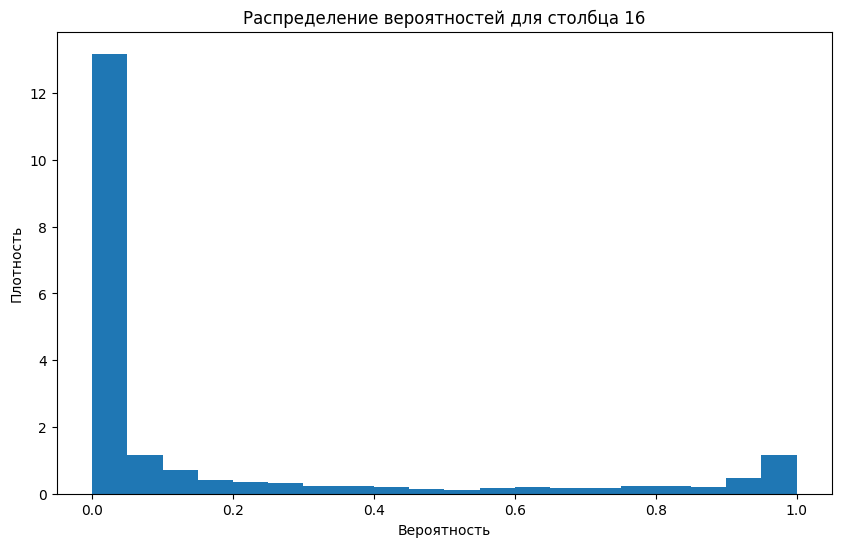

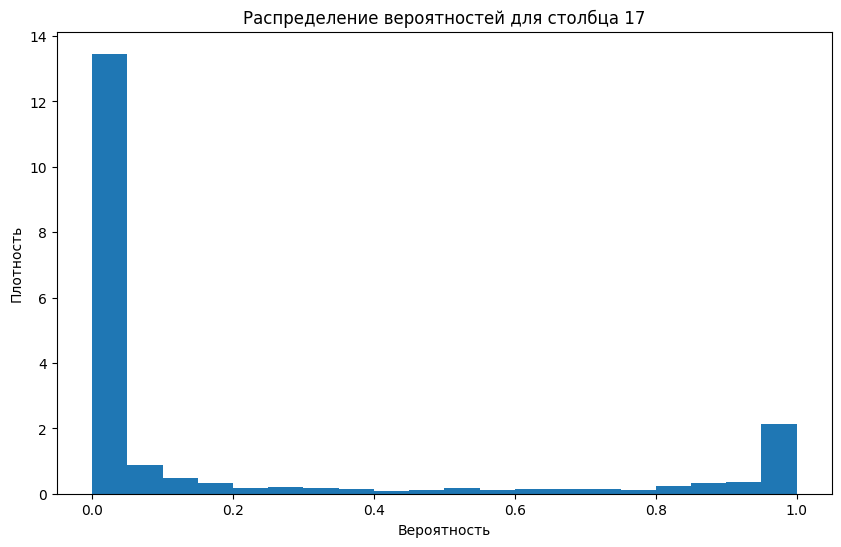

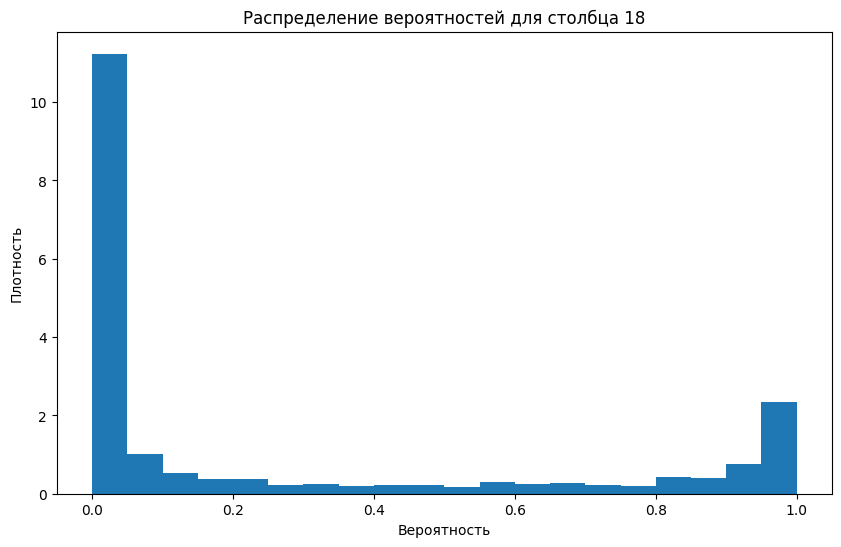

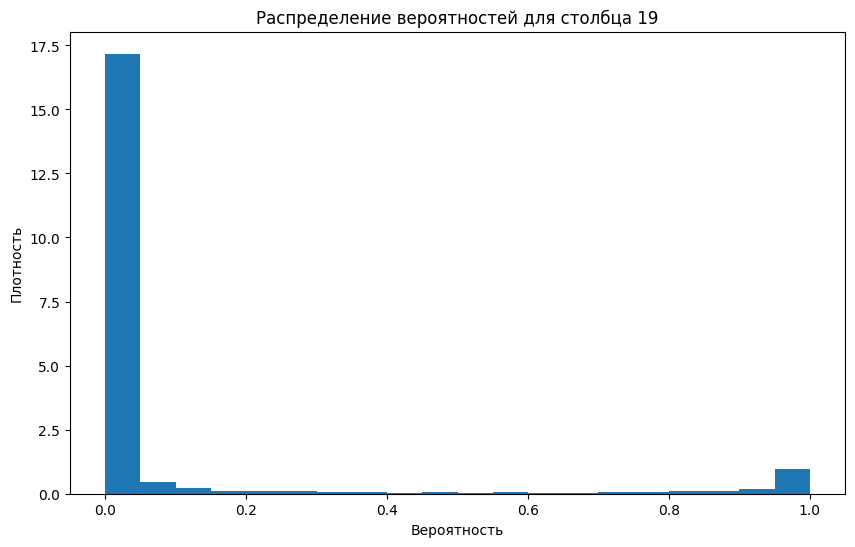

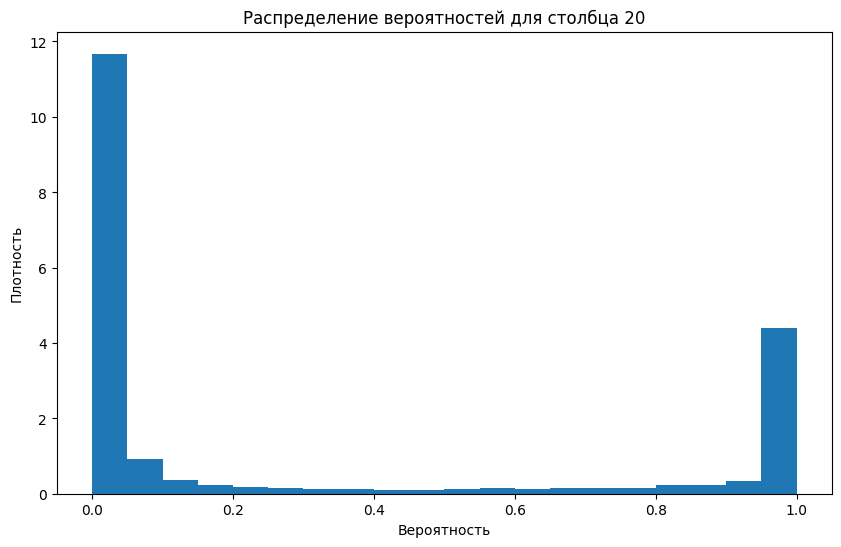

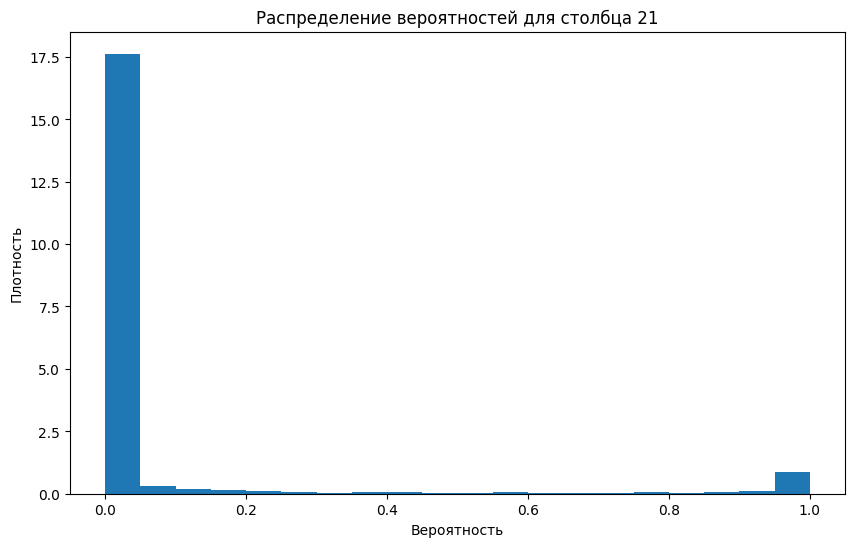

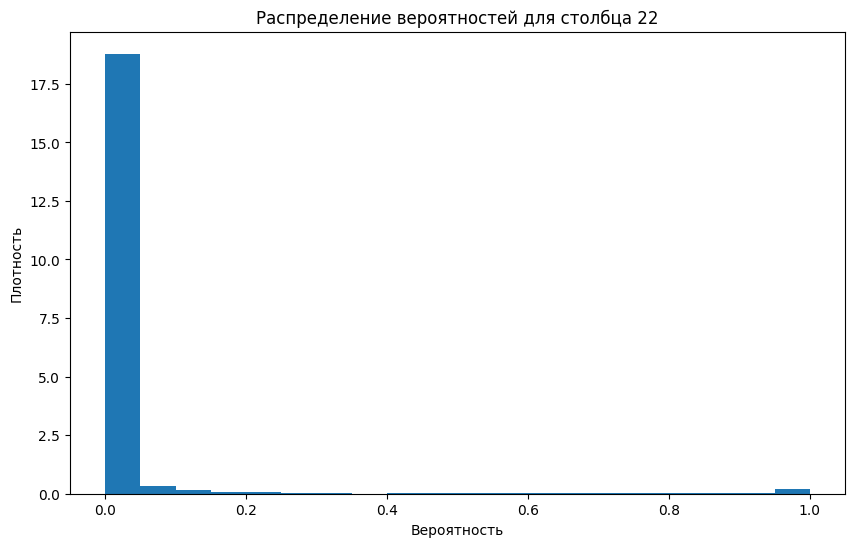

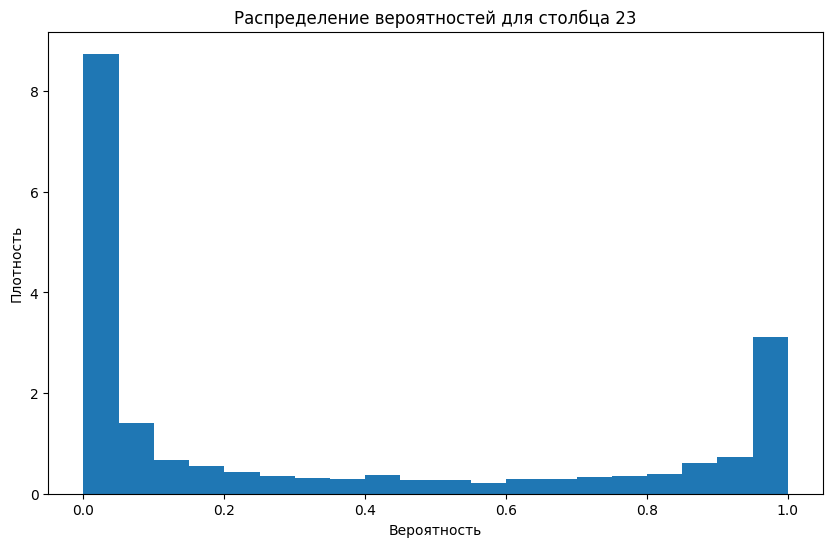

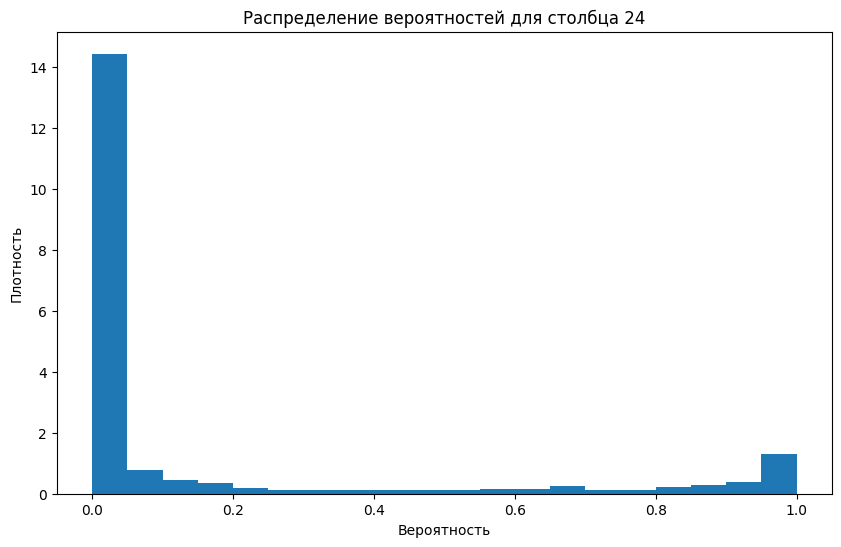

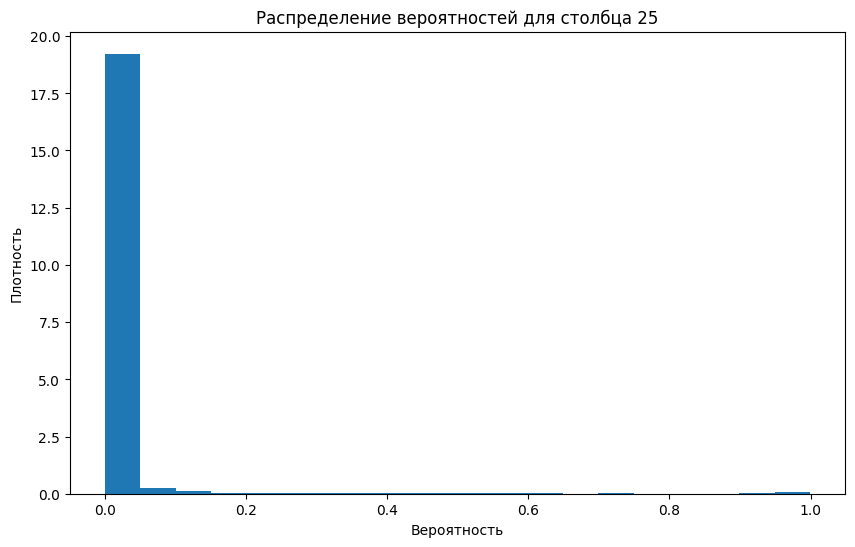

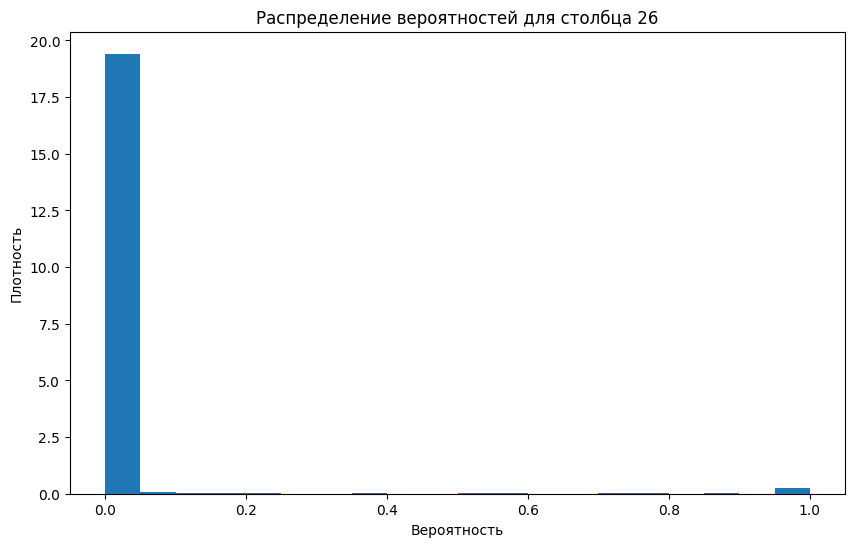

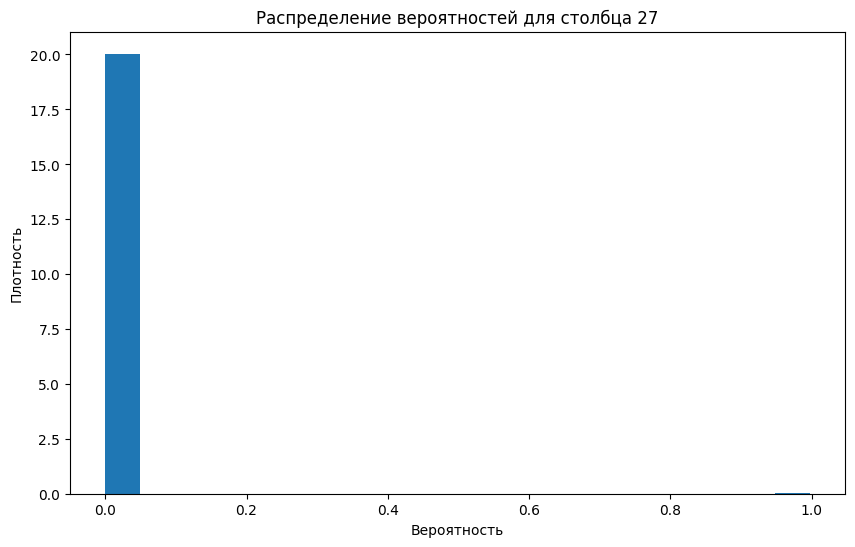

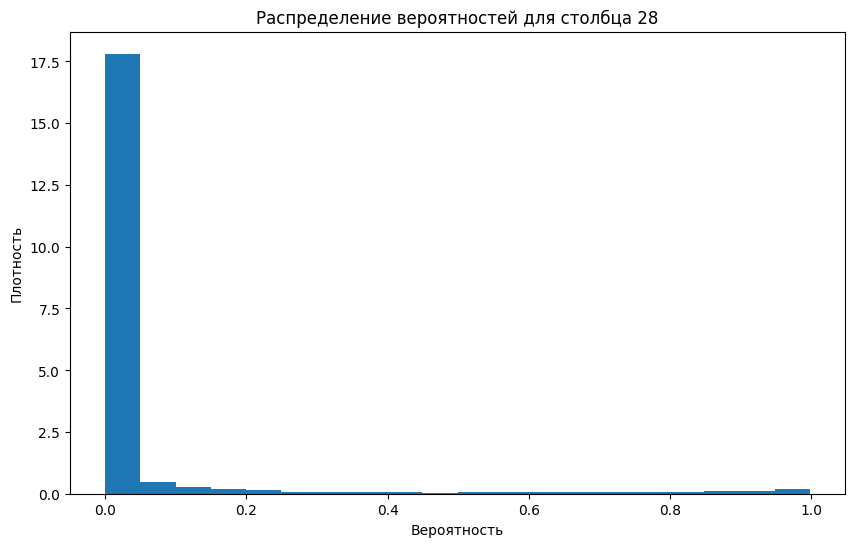

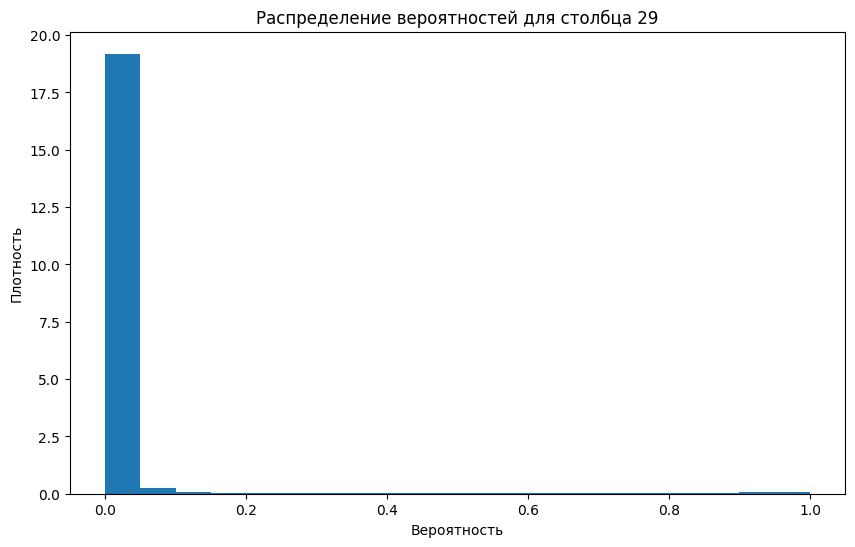

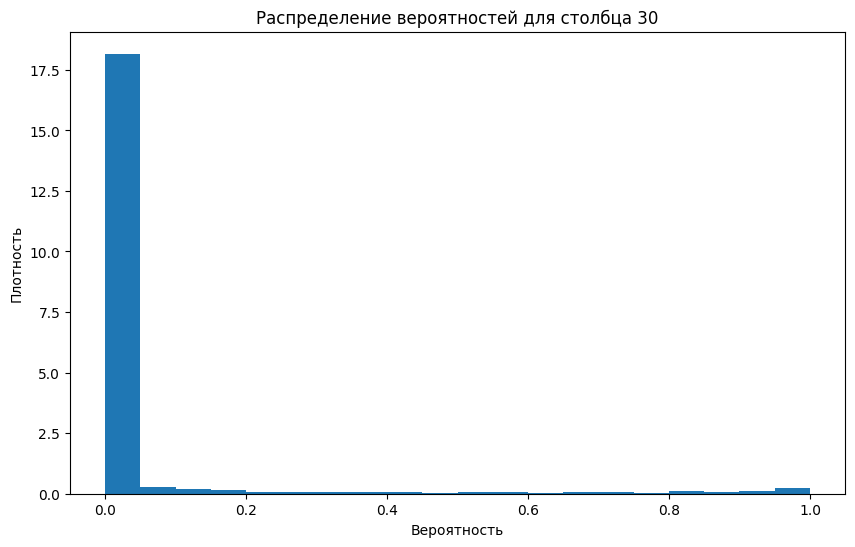

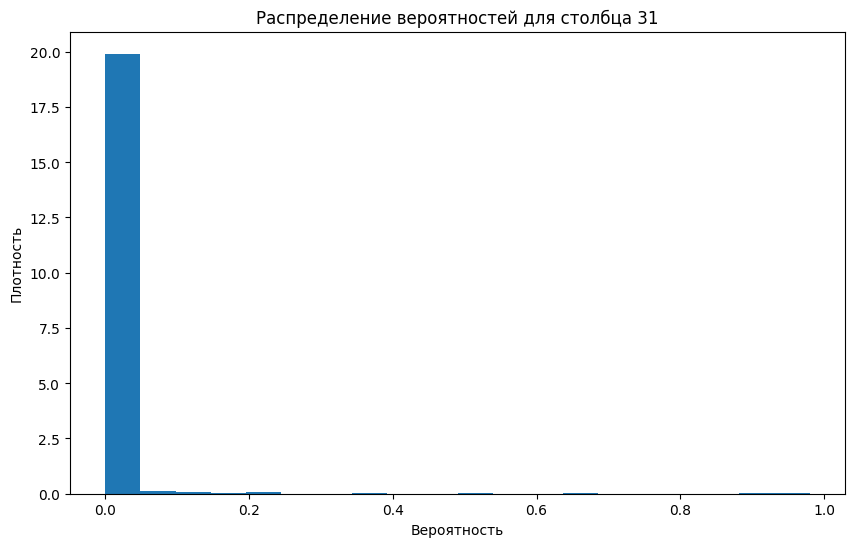

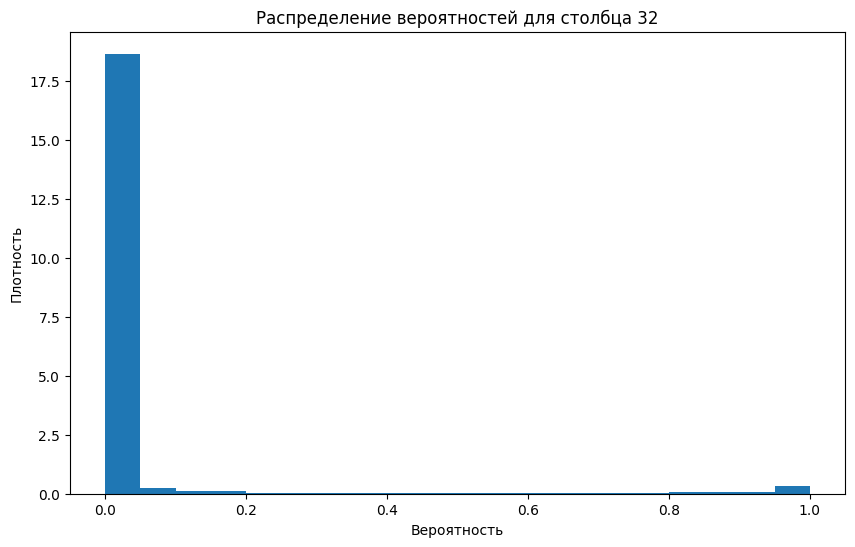

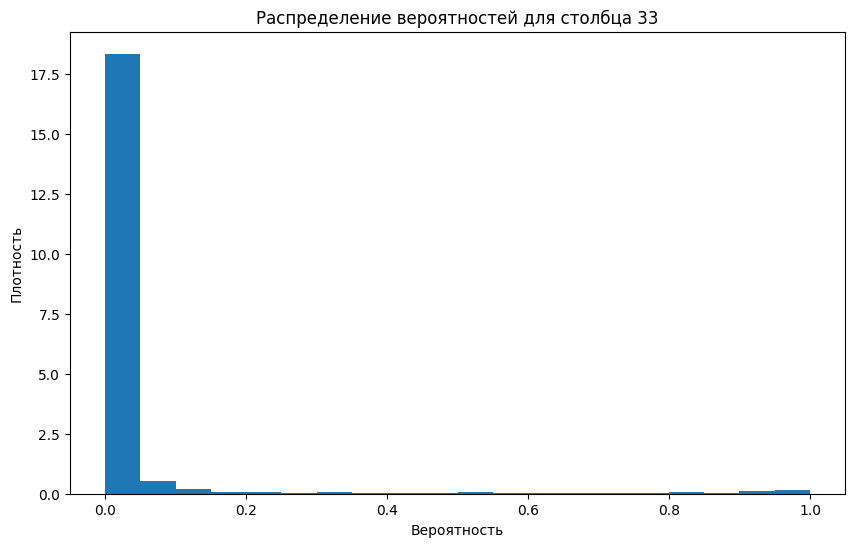

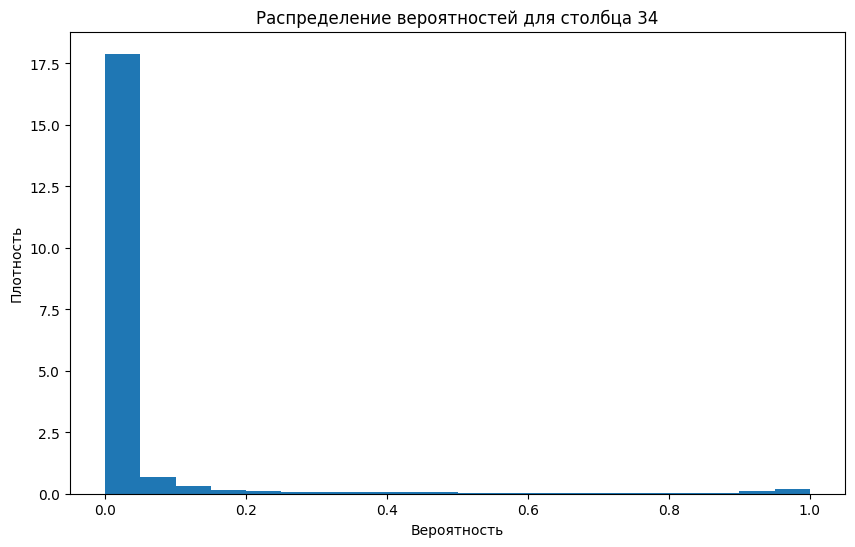

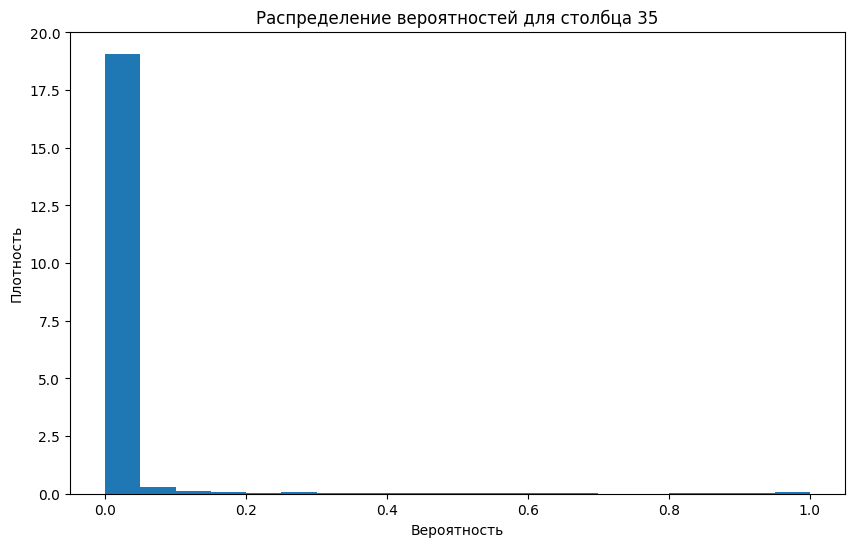

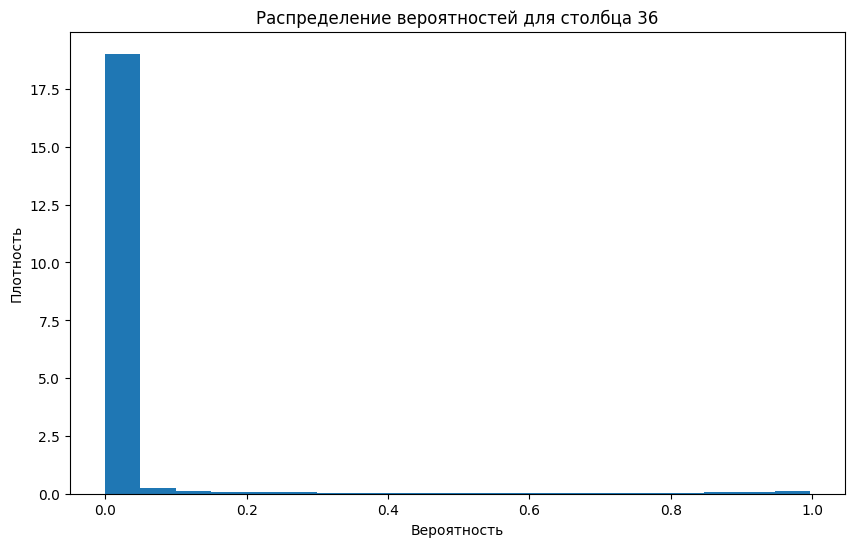

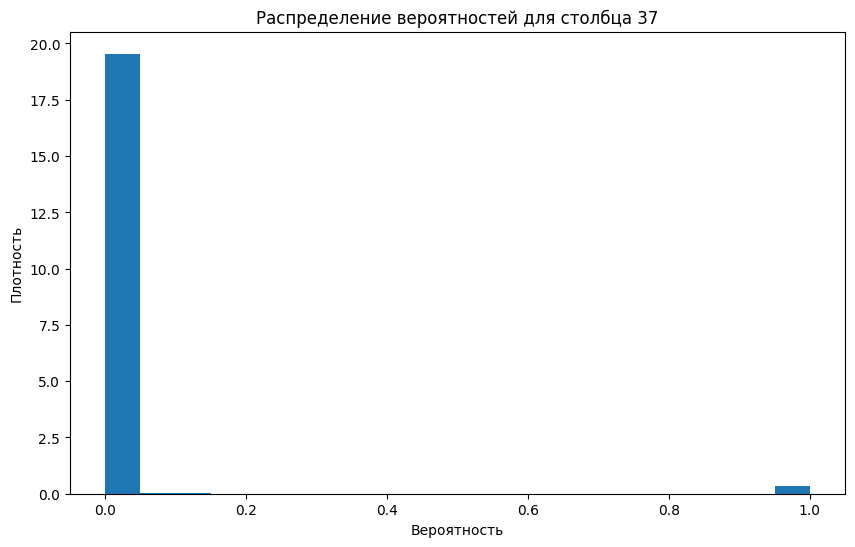

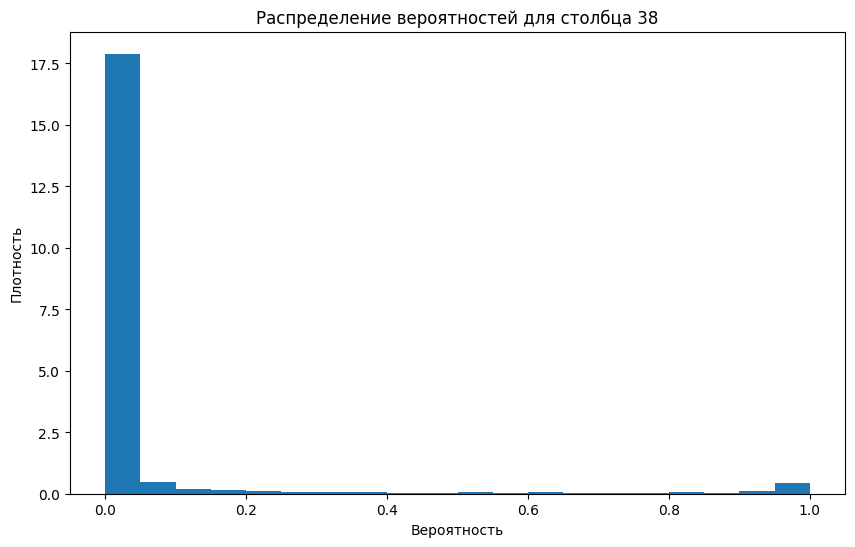

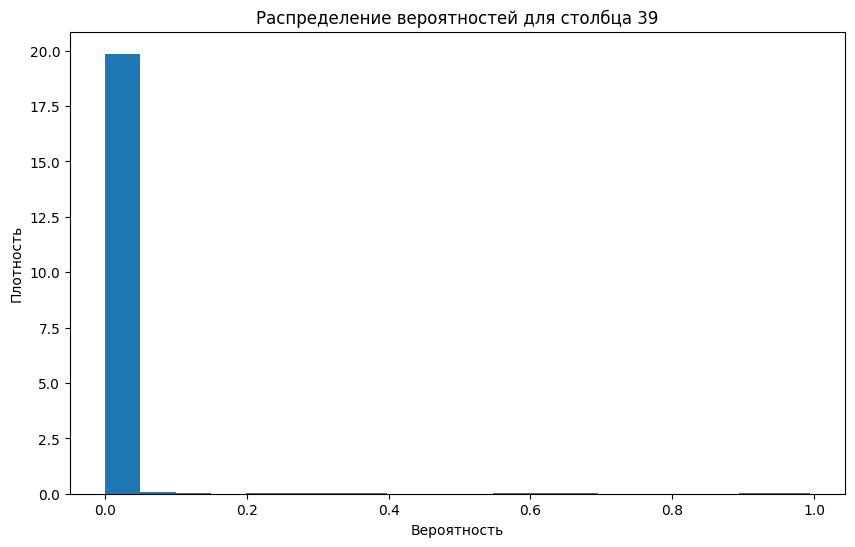

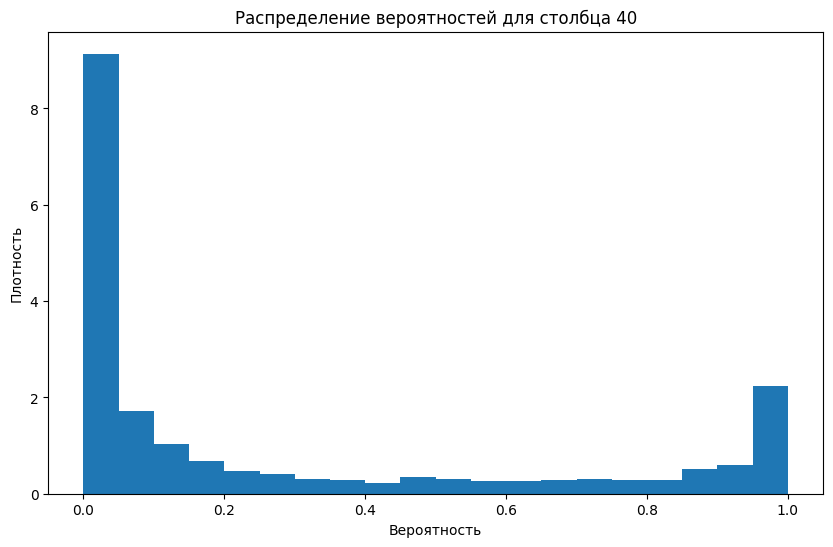

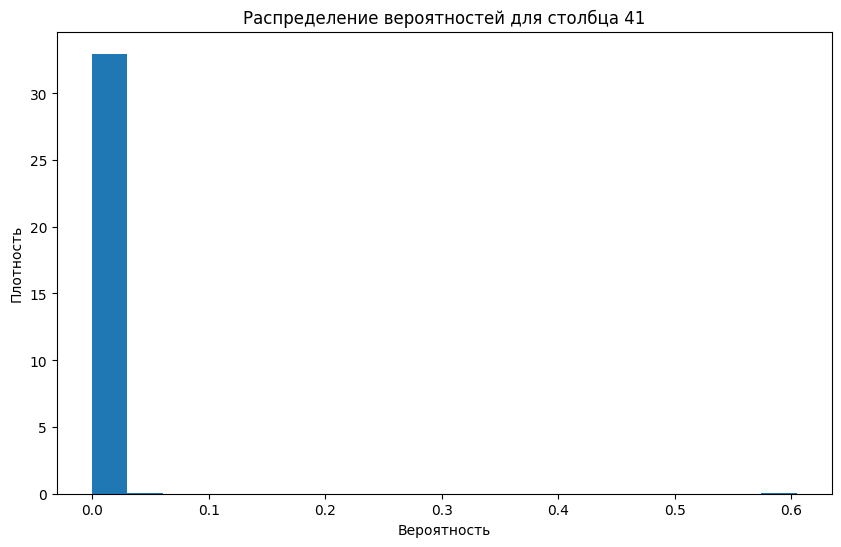

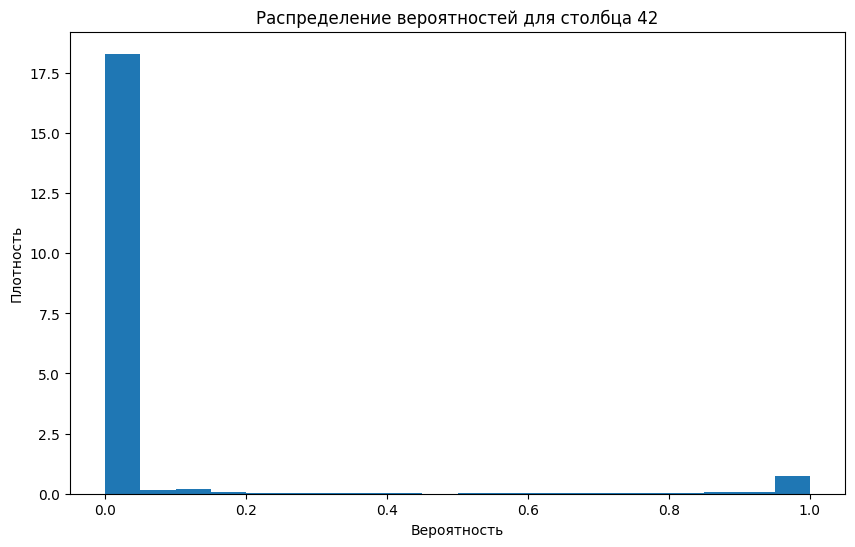

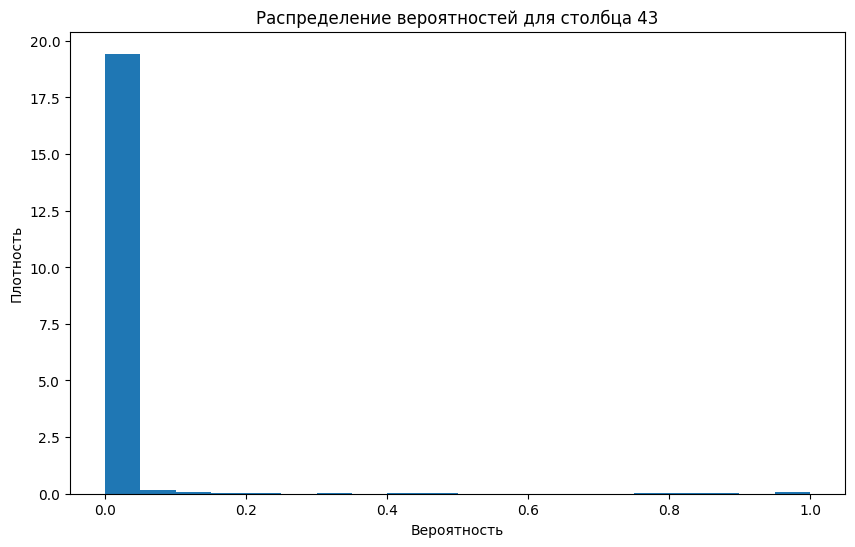

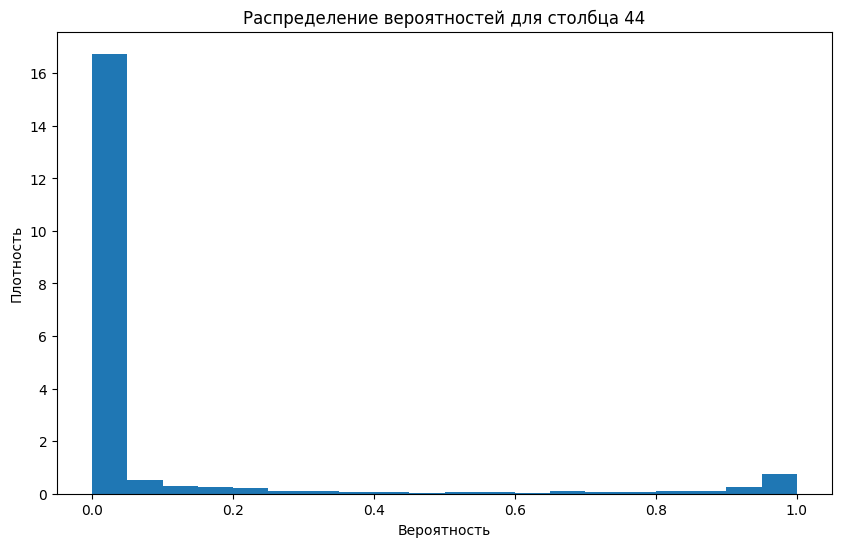

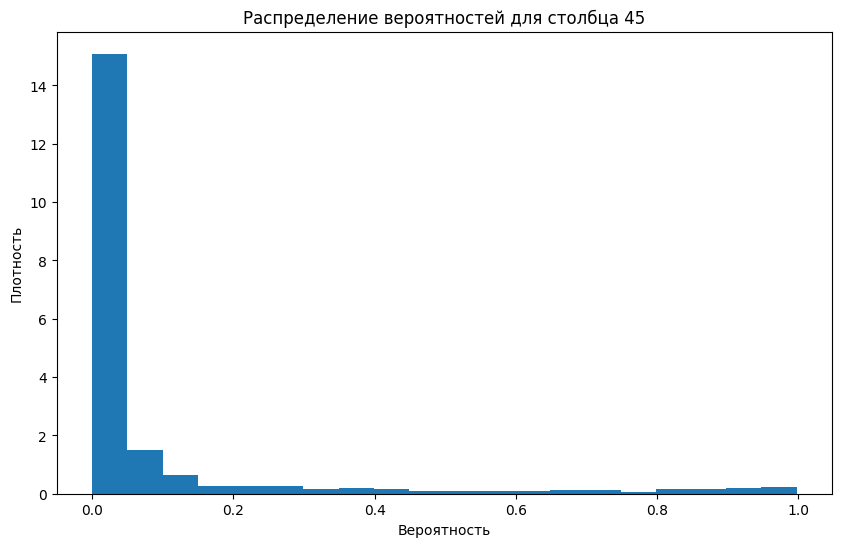

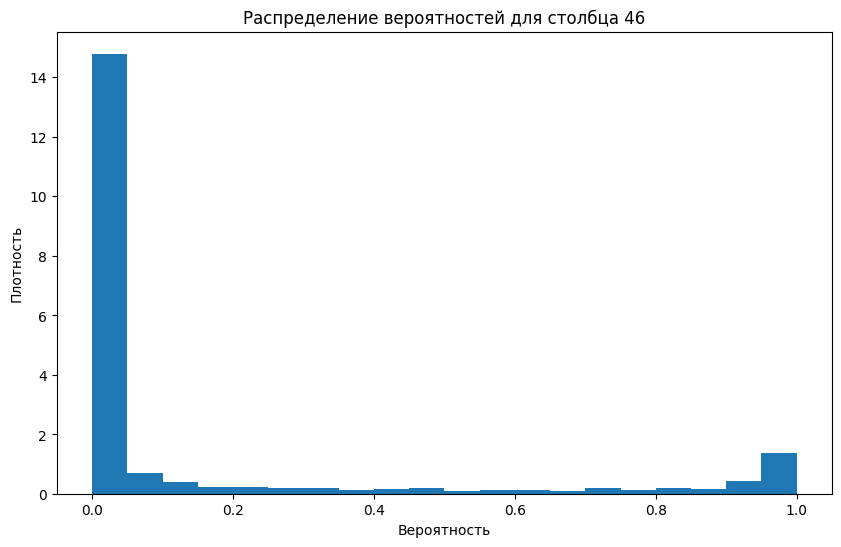

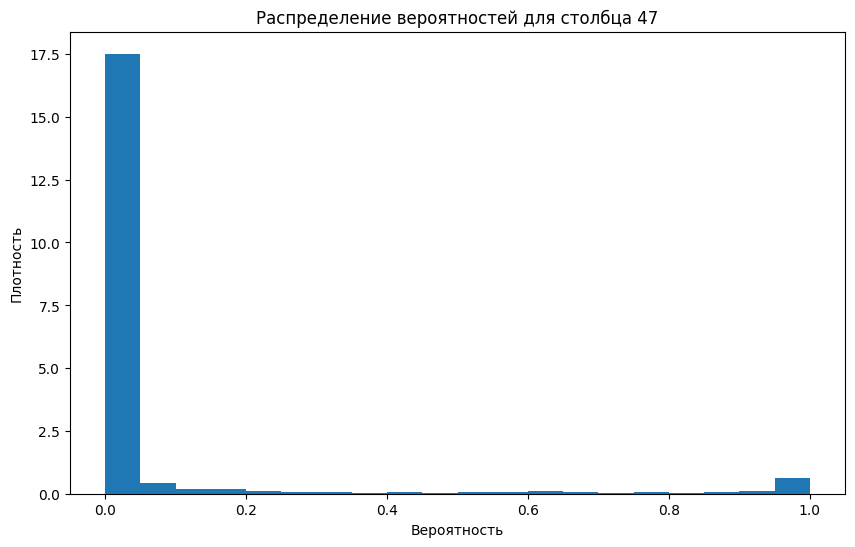

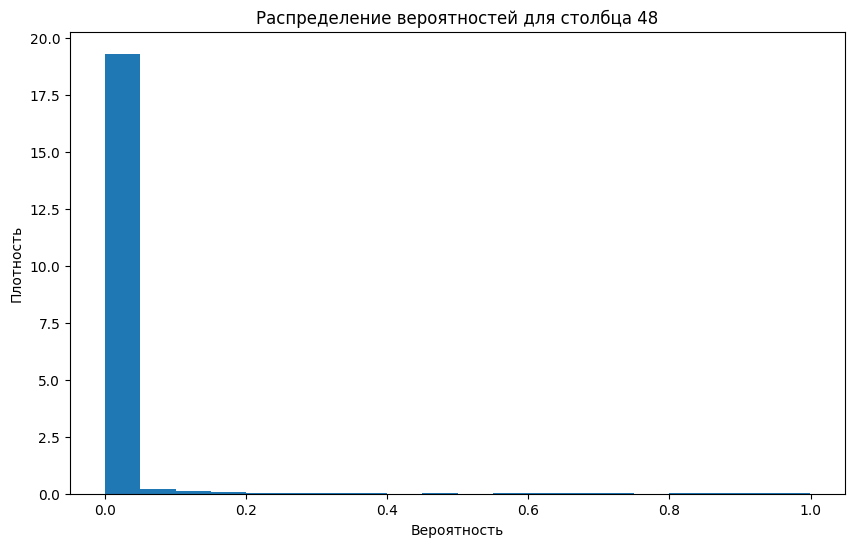

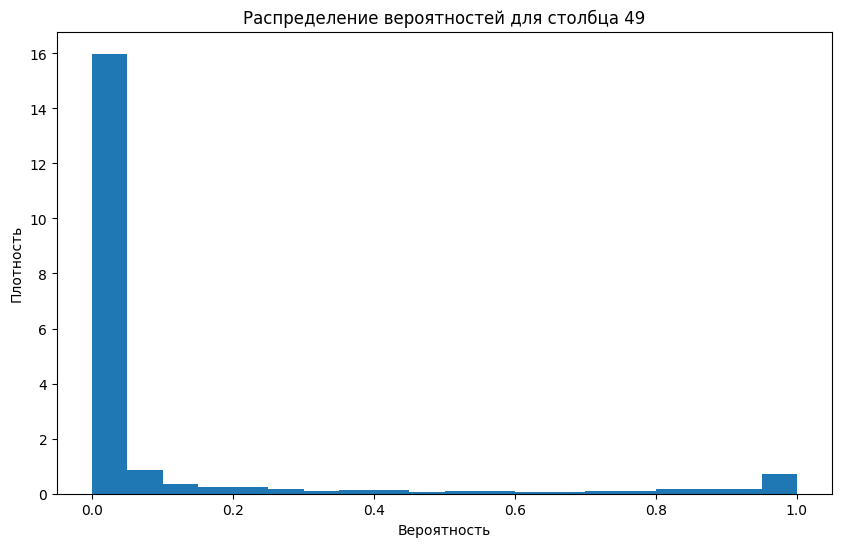

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Предположим, что `matrix` - это ваша исходная матрица размером 256x49
matrix = np.random.rand(256, 49)

# Нарисуем график для каждого столбца
for i in range(49):
    plt.figure(figsize=(10, 6))
    plt.hist(all_preds[:, i], bins=20, density=True)
    plt.title(f'Распределение вероятностей для столбца {i+1}')
    plt.xlabel('Вероятность')
    plt.ylabel('Плотность')
    plt.show()